<h3>Nuclear Energy (NE): does it reduce CO2?</h3>
<p>list of things that we have to asses:</p>
<ul>
  <li>Could we correlate the GDP to the emmision of CO2? (we can show the correlation BEFORE introduction of NE)</li>
  <li>Can we show that countries that adopted NE have a different behaviour in terms of GDP growth and the emmision of CO2 growth?</li>
  <li>Can we show the share of nuclear energy with respect of the total energy?</li>
  <li>Can we notice a relative reduction of CO2 in countries in which we measure a strong adoption (in terms of share) of nuclear energy?</li>
</ul>

# Data import

In [1]:
#imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats
import warnings

#config
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
path = 'plots/'
plt.rcParams.update({"text.usetex" : True,
                     'font.family' : 'sans-serif',
                     "text.latex.preamble" : r"\usepackage{avant} \usepackage{sansmath} \sansmath"})

In [2]:
#Load hosted data
data_url = 'https://www.ingmarzo.it/data/'
co2 = pd.read_csv(data_url + 'co2.csv', header=1, error_bad_lines=False, sep=';') #import OK The Global Carbon Budget 2020 (see citation in file)
gdp = pd.read_csv(data_url + 'gdp.csv', header=2) #import OK WORLD BANK DATA
energy = pd.read_excel(data_url + 'energy.xlsx', 
                       sheet_name='Primary Energy Consumption',
                       header=2) #import OK OUR WORLD IN DATA 2
nuclear = pd.read_csv(data_url + 'nuclear.csv') #import OK GAPMINDER
nuclear_adj = pd.read_excel(data_url + 'energy.xlsx', 
                       sheet_name='Nuclear Consumption - EJ',
                       header=2) #import OK OUR WORLD IN DATA 2

In [3]:
#Shape of datasets
print('co2: ', co2.shape, ' gdp: ', gdp.shape, 'nuclear: ', nuclear.shape, ' energy: ', energy.shape, 'nuclear adj', nuclear_adj.shape)

co2:  (62, 222)  gdp:  (266, 66) nuclear:  (136, 53)  energy:  (121, 62) nuclear adj (122, 62)


In [4]:
#Color settings
dark_blue = '#253f5d' #dark blue
blue = '#4e7aa5' #blue
green = '#4ea37f' #green
light_green = '#a0c8b5' #light green

# Cleaning CO2 Data
Select only data from 1965 to 2010, substitute NA/NaN values with 0.

In [5]:
years = [str(i) for i in range(1965, 2010 + 1)]
co2_clean = co2[co2.iloc[:, 0].isin(years)].copy() #select by years
co2_clean = co2_clean.iloc[:, 1:].sum(axis=1) #sum columns (excluding year)
co2_clean = list(zip(years, co2_clean)) #include years
co2_clean = pd.DataFrame(co2_clean, columns = ['Year', 'Total CO2 emissions'])

#normalize
co2_normal = co2_clean.copy()
co2colname = 'Total CO2 emissions'
co2_normal[co2colname] = MinMaxScaler().fit_transform(np.array(co2_normal[co2colname]).reshape(-1,1))

#Generate Series to plot
co2_normal = pd.Series(co2_normal['Total CO2 emissions'].values, index=co2_normal['Year'])

# Cleaning GDP Data


In [6]:
gdp_clean = gdp.loc[:, years].copy()
gdp_clean = gdp_clean.sum(skipna = True)
gdp_clean = list(zip(years, gdp_clean))

#normalize
gdp_normal = pd.DataFrame(gdp_clean, columns=['Year', 'gdp'])
gdpcolname = 'gdp'
gdp_normal[gdpcolname] = MinMaxScaler().fit_transform(np.array(gdp_normal[gdpcolname]).reshape(-1,1))

#Generate Series to plot
gdp_normal = pd.Series(gdp_normal[gdpcolname].values, index=gdp_normal['Year'])

In [7]:
#Calculate correlation
#https://realpython.com/numpy-scipy-pandas-correlation-python/
pearsonr = scipy.stats.pearsonr(gdp_normal.values, co2_normal.values)[0]
spearmanr = scipy.stats.spearmanr(gdp_normal.values, co2_normal.values).correlation
kendalltau = scipy.stats.kendalltau(gdp_normal.values, co2_normal.values).correlation
print(pearsonr, spearmanr, kendalltau)

0.9625884171425348 0.991859389454209 0.9497584541062802


# Plot n.1: GDP and CO2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


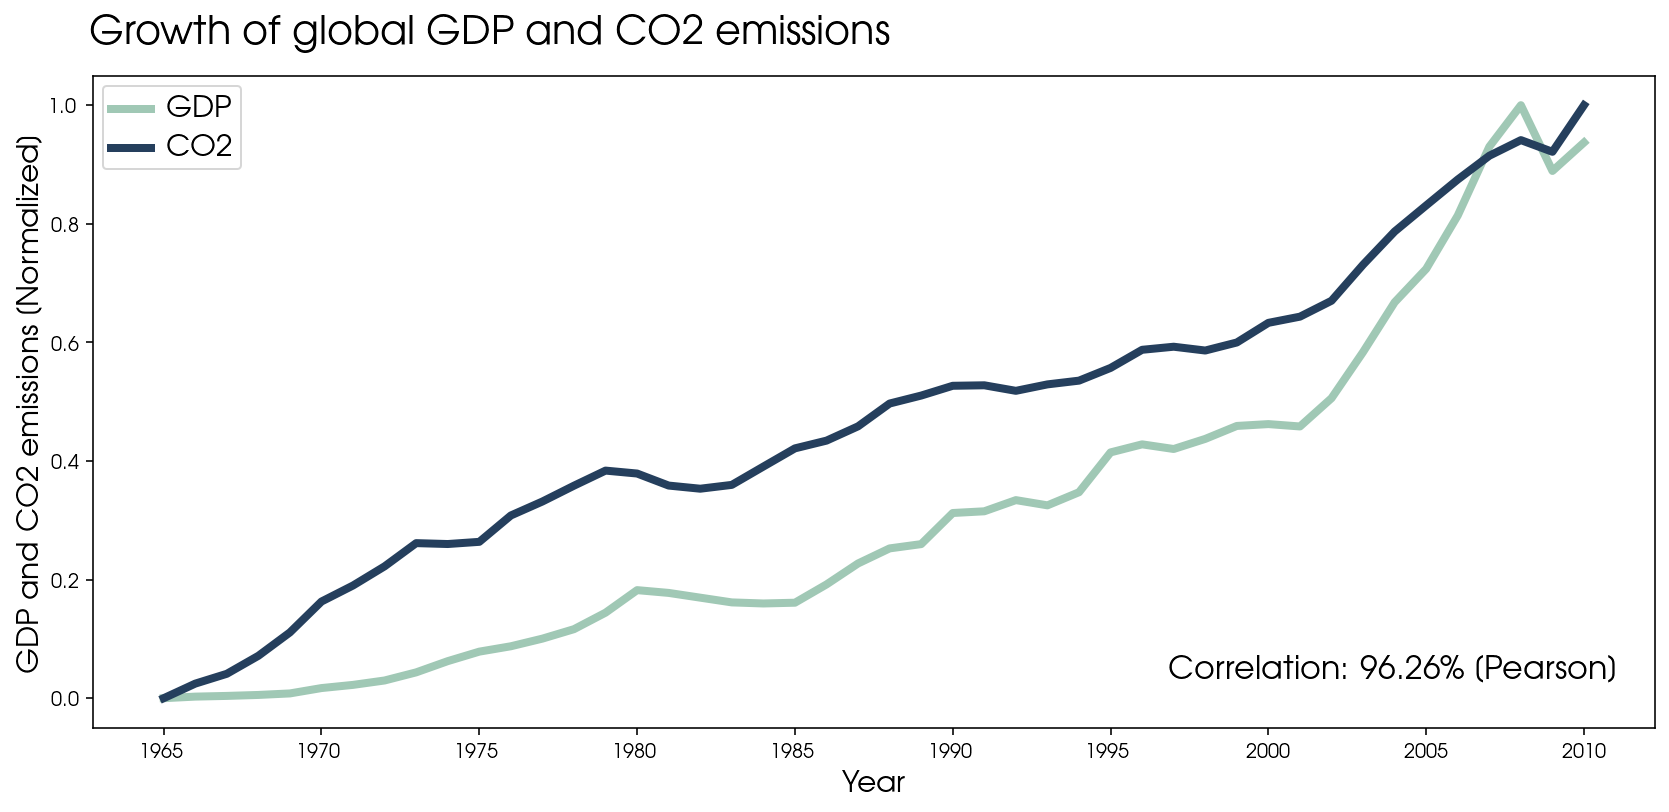

In [8]:
plt.figure(figsize=(14, 6))
#colors
gdp_col = light_green
co2_col = dark_blue
line_width = 4
labels_font_size = 15

ax = plt.subplot()
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)

plt.plot(gdp_normal, color=gdp_col, linewidth=line_width)
plt.plot(co2_normal, color=co2_col, linewidth=line_width)


leg = plt.legend(['GDP', 'CO2'], loc='upper left')
for line in leg.get_lines():
    line.set_linewidth(line_width) #enlarge legend line
for text in leg.get_texts():
    text.set_fontsize(labels_font_size)
plt.xlabel("Year", fontsize=labels_font_size)
plt.ylabel("GDP and CO2 emissions $[$Normalized$]$", fontsize=labels_font_size)
#plt.xticks(rotation=40, ha="right") #diagonal labels
plt.xticks(np.arange(0, len(co2_normal) + 1, 5)) #5 years interval

plt.title('Growth of global GDP and CO2 emissions', fontsize=labels_font_size+5, y=1.03, x=.255)
plt.text(39, 0.05,'Correlation: ' + str(round((pearsonr*100),2)) + '\% $[$Pearson$]$',
     horizontalalignment='center',
     verticalalignment='center',
     fontsize=labels_font_size+1)
plt.savefig(path + '01.eps', format='eps')
plt.show()

# Find countries that reduced CO2 emissions
- find maximum emissions per country $M$
- subtract emissions of 2010 $E$
- calculate $S = M - E$
- select countries where $S > 0$ i.e. emissions reduction
- order countries by $S$ decrescent <br>
Table result will have the following shape: <br>
COUNTRY | YEAR MAX EMISSION | MAX EMISSIONS (M) | EMISSIONS 2010 (E) | EMISSION DIFFERENCE (S)

In [9]:
co2_columns = ['Year max emissions', 'Max emissions', 'Last year emissions', 'country']
co2_clean = co2[co2.iloc[:, 0].isin(years)].copy() #select by years
co2_clean.dropna(how='all', axis=1, inplace=True) #drop NaN columns (No data)
co2_countries = co2_clean.copy().columns.to_list()
co2_countries.pop(0)

'Unnamed: 0'

In [10]:
co2_table = pd.DataFrame()
row_list = []
for i in range(len(co2_countries)):
  #create a row to store data
  co2_row = pd.DataFrame()

  #get year max emission and emission value
  co2_max = co2_clean.loc[co2_clean[co2_countries[i]] == co2_clean[co2_countries[i]].max()].copy()#get max emissions for country i
  #filter column for country i got (YEAR MAX EMISSIONS, EMISSIONS)
  co2_max = co2_max.iloc[:1, [0,i+1]] #if max emissions has more than one result, keep the first
  co2_max.columns = ['Year max emissions', 'Max emissions'] #change column name

  co2_row['Year max emissions'] = co2_max['Year max emissions']
  co2_row['Max emissions'] = co2_max['Max emissions']
  row_list.append(co2_row)
  
#put rows in table
co2_table = pd.concat(row_list)


co2_table['Country'] = co2_countries
# get all countries emissions in last year selected
co2_last_year = co2_clean.loc[co2_clean[co2_clean.columns.to_list()[0]] == str(years[-1])].copy() 
co2_last_year = co2_last_year.iloc[:, 1:] #get Last year emissions for i-th country
co2_table['Last year emissions'] = co2_last_year.transpose().values

#calculate difference
co2_diff = pd.to_numeric(co2_table['Max emissions']) - pd.to_numeric(co2_table['Last year emissions'])
co2_table['Emissions difference'] = co2_diff

#select only countries with positive difference
co2_table = co2_table.loc[co2_table['Emissions difference'] > 0]

#remove outlier values
q = co2_table['Emissions difference'].quantile(.99)
co2_table = co2_table[co2_table['Emissions difference'] < q]

#sort values
co2_table = co2_table.sort_values('Emissions difference', ascending=False)

#Create CO2 Topten
co2_topten = co2_table.iloc[0:10, :].copy()


# Cleaning the nuclear energy Dataset

In [11]:
countries = list(co2_topten['Country'].values)
#select only countries that belongs to the top ten
nuclear_clean = nuclear.loc[nuclear['country'].isin(countries)].copy()
#Select only years in range
nuclear_clean = nuclear_clean.loc[:, ['country'] + years] #select by years
nuclear_clean = nuclear_clean.fillna(0)
#select all countries which have 0 nuclear energy production
zero_nuclear = nuclear_clean.loc[nuclear_clean[years[-1]] == '0']['country'].copy()
nuclear_clean = nuclear_clean.loc[~nuclear_clean['country'].isin(zero_nuclear)]
#zero_nuclear

# Plot n.2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


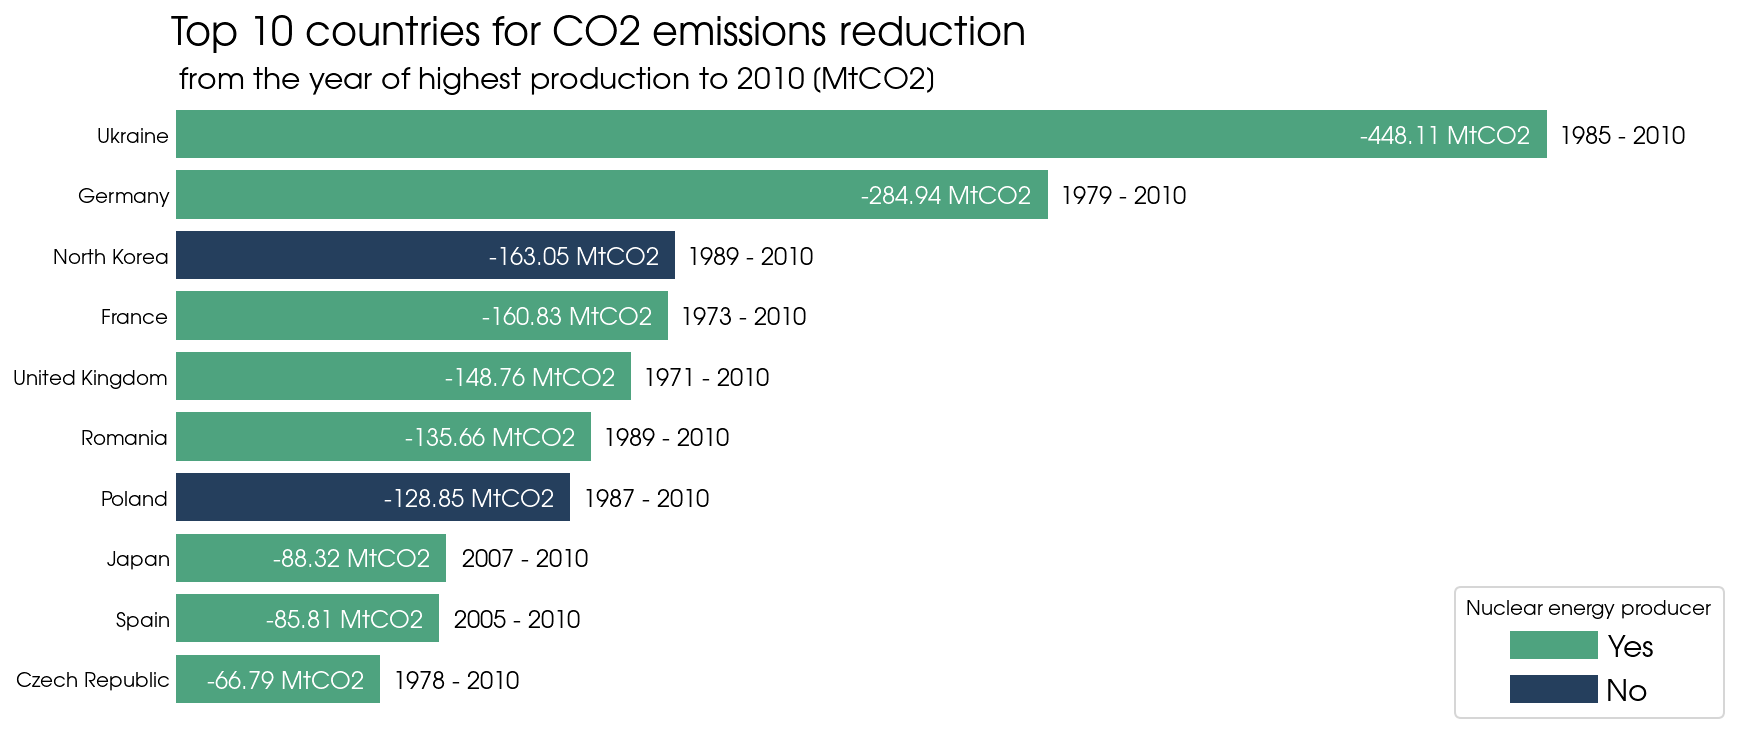

In [12]:

# Plot n.2
#on the y axis we show the top 10 countries

#colors
no_nuc = dark_blue
nuc = green

#plot size
plt.figure(figsize=(14, 6))

#list of information to plot
countries = list(reversed(co2_topten['Country'].values))
reduction = list(reversed(co2_topten['Emissions difference'].values))
year = list(reversed(co2_topten['Year max emissions'].values))
co2value = list(reversed(co2_topten['Emissions difference'].values))

y_pos = np.arange(len(countries))

#change bar color
bar_colors = [no_nuc if country in zero_nuclear.to_list() else nuc for country in countries]

#plot
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax.tick_params(axis=u'both', which=u'both',length=0)
bar = ax.barh(y_pos, co2value, align='center', color=bar_colors)
plt.yticks(y_pos, countries)
plt.text(1.01,9.75,'from the year of highest production to '+str(years[-1])+' $[$MtCO2$]$', fontsize=labels_font_size)
#plt.ylabel('Top 10 countries', fontsize=labels_font_size)
plt.title('Top 10 countries for CO2 emissions reduction', fontsize=labels_font_size+5, x=.27, y=1.038)

#add Tons of CO2 informations in bar
for i in range(len(bar)):
    height = bar[i].get_y() + (bar[i].get_height()/4.5)
    #plot Ton
    plt.text(bar[i].get_width() - 5, height, 
             '-' + str(round(reduction[i], 2)) + ' MtCO2', ha='right', 
             va='bottom', color='white', fontsize=labels_font_size-3)
    #plot range of years
    plt.text(bar[i].get_width() + 5, height, 
             str(year[i]) + ' - ' + str(years[-1]), ha='left', 
             va='bottom', color='black', fontsize=labels_font_size-3)
    
#leave a margin for showing years
plt.margins(x=.14)

#legend: build a custom legend 
#matplotlib docs: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html 
custom_lines = [Line2D([0], [0], color=nuc, lw=14),
                Line2D([0], [0], color=no_nuc, lw=14)]
leg = ax.legend(custom_lines, ['Yes', 
                                'No'],
                 title='Nuclear energy producer', fontsize=labels_font_size)
for text in leg.get_texts():
    text.set_fontsize(labels_font_size)
plt.savefig(path + '02.eps', format='eps')
plt.show()

# Clean Energy dataset

In [13]:
#select top four (for CO2 reduction) nuclear countries
co2_topfour = co2_topten.loc[co2_topten['Country'].isin(nuclear_clean['country'])].iloc[:4, :]
#select the minimum year from 'Year max emissions'
min_year = co2_topfour['Year max emissions'].min()
yearspan = list(range(int(min_year), (int(years[-1]) + 1)))
energy_clean = energy.loc[energy['Exajoules'].isin(co2_topfour['Country'])].loc[:, ['Exajoules'] + yearspan].fillna(0).copy()

# Calculate nuclear energy share and emissions for top four countries

In [14]:
energy_clean = energy.loc[energy['Exajoules'].isin(co2_topfour['Country'])].loc[:, ['Exajoules'] + yearspan].fillna(0).copy()

#convert k and M in *10^3, *10^6 in nuclear energy dataset

#create new dataframe 
nuclear_conv = pd.DataFrame()
toe_to_exajouls = '*4.1868e-8*2.824'
c_list = co2_topfour['Country'].to_list()
nuclear_clean = nuclear_clean.loc[nuclear_clean['country'].isin(c_list)]
c_list = nuclear_clean['country'].to_list() #list is ordered and we can iterate

for i in range(len(c_list)):
  nuclear_conv[c_list[i]] = nuclear_clean.T.iloc[1:, 
                                                 i].replace({'k': '*1e3'+toe_to_exajouls, 
                                                             'M': '*1e6'+toe_to_exajouls}, 
                                                            regex=True).map(pd.eval).astype(float).copy()

nuclear_conv = nuclear_conv.T
nuclear_conv = nuclear_conv[map(str, yearspan)] #use only data in yearspan

#Create the table topfour_co2emisisons for top four countris with this values:
#Country | ... | Year | ... | -> in Year column put the co2 emissions

topfour_co2emisisons = co2_clean[['Unnamed: 0'] + c_list] #get only top4 countries
topfour_co2emisisons.columns = ['Country'] + c_list #rename first column (it will contain country)
#filter only years in span
topfour_co2emisisons = topfour_co2emisisons.loc[topfour_co2emisisons['Country'].astype(int) >= yearspan[0]].T
#get first row as new header
new_head = topfour_co2emisisons.iloc[0]
topfour_co2emisisons = topfour_co2emisisons[1:]
topfour_co2emisisons.columns = new_head
topfour_co2emisisons


#Create the table topfour_nuclearshare for top four countris with this values:
#Country | ... | Year | ... | -> in Year column put the nuclear enery share
energy_clean #contains energy in exajouls in year-span
nuclear_conv = nuclear_conv.reset_index(level=[0]) #fit to the shape of energy_clean
new_head = ['Country'] + yearspan

#set new indexes to energy_clean and nuclear_conv
energy_clean.columns = new_head
nuclear_conv.columns = new_head
energy_clean = energy_clean.sort_values('Country')
nuclear_conv = nuclear_conv.sort_values('Country')
#calculate share in %
share_countries = nuclear_conv.iloc[:, :1]
nuclear_conv = nuclear_conv.iloc[:, 1:].astype(float)
energy_clean = energy_clean.iloc[:, 1:].astype(float)

nuclear_share = nuclear_conv.to_numpy() / energy_clean.to_numpy()
nuclear_share = pd.DataFrame(nuclear_share)
nuclear_share['Country'] = share_countries.values
nuclear_share = nuclear_share.fillna(0)
#share is calculated: nuclear energy / total energy

# After data checking it is more accurate to use data from the same source

In [15]:
#Cleaning nuclear energy consuption (adjusted)
first_col = 'Exajoules (input-equivalent)'
nuclear_adj_clean = nuclear_adj.loc[nuclear_adj[first_col].isin(co2_topfour['Country'])].loc[:, [first_col] + yearspan].fillna(0).copy()
nuclear_adj_clean = nuclear_adj_clean.sort_values(first_col)
nuclear_adj_clean = nuclear_adj_clean.iloc[:, 1:].astype(float)
nuclear_share_adj = nuclear_adj_clean.to_numpy() / energy_clean.to_numpy()
nuclear_share_adj = pd.DataFrame(nuclear_share_adj)
nuclear_share_adj = nuclear_share_adj.fillna(0)
nuclear_share_adj.columns = yearspan
nuclear_share_adj['Country'] = share_countries.values

# Plot n.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


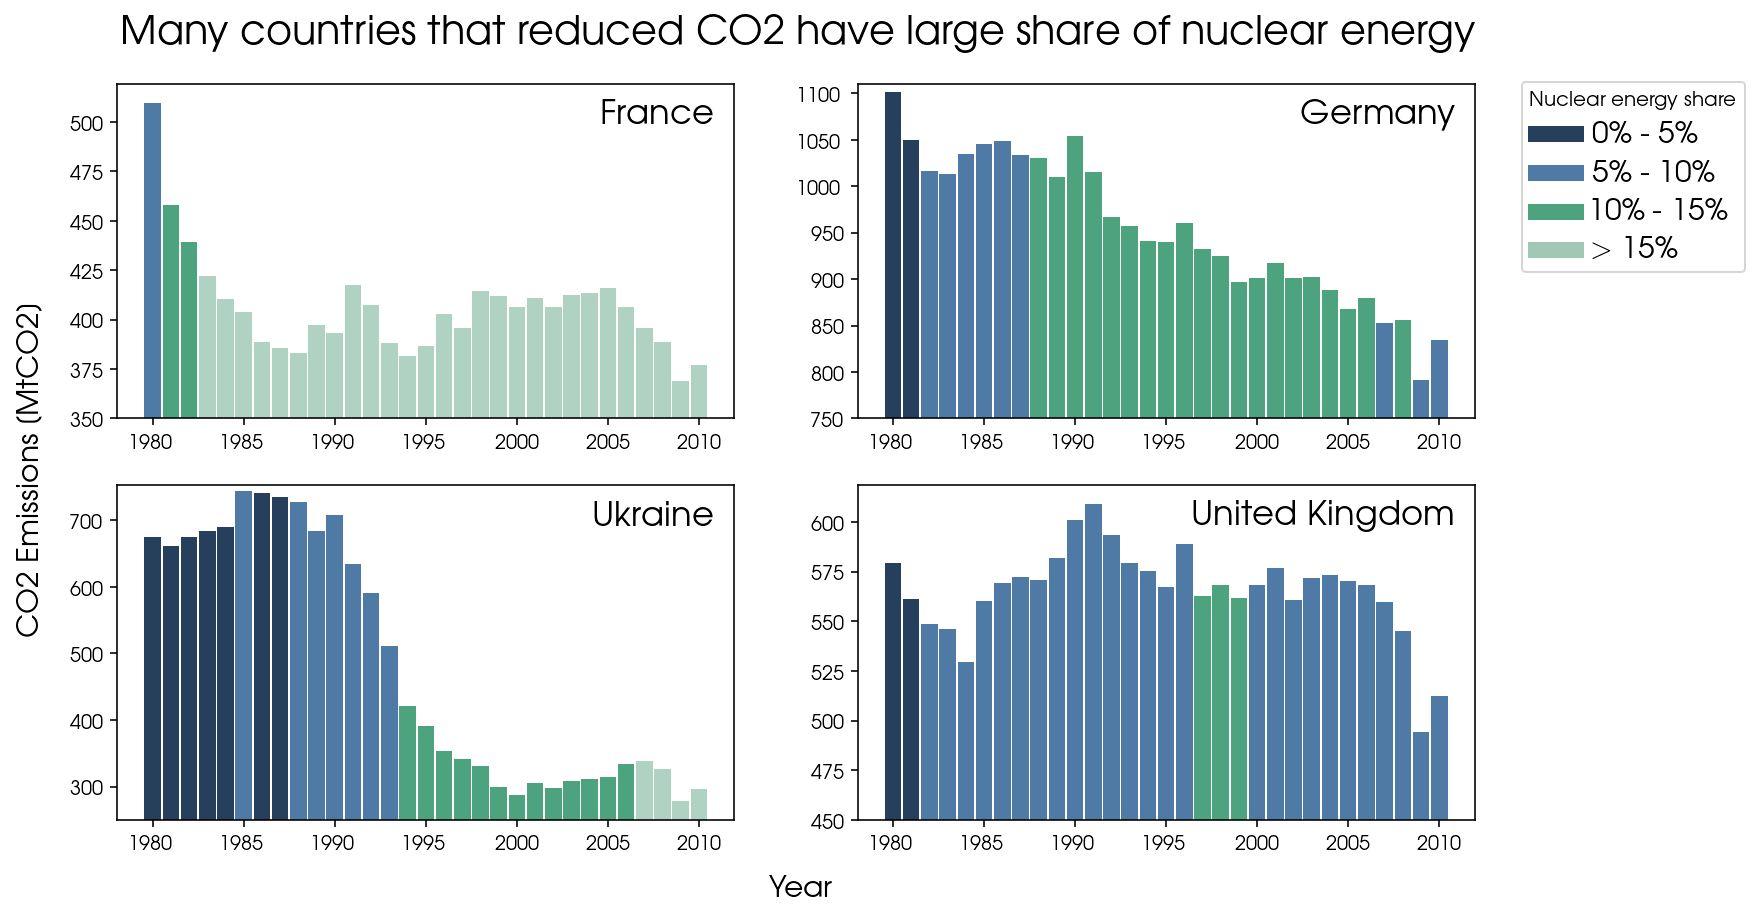

In [16]:
def min(l):
    m = l[0]
    for el in l: 
        if el < m: 
            m = el
    return m

#bar colors
    #0 - 5%     -> dark blue
    #5 - 10%    -> blue
    #10 - 15%   -> green
    # > 15%     -> light green
def colortomap(x):
    x = float(x)
    if x < .05:
        return '#253f5d' #dark blue
    elif x < .1:
        return '#4e7aa5' #blue
    elif x < .15:
        return '#4ea37f' #green
    else:
        return '#b0d2c3' #light green

num_of_countries = 4
years_ago = -31 # negative, not smaller than -32
margin = 10
step = 50
fig, axs = plt.subplots(2, 2, figsize = (13,7))
fig.suptitle('Many countries that reduced CO2 have large share of nuclear energy', 
             fontsize=labels_font_size+5, y=.95, x=0.49)

index = 0
for index_i in range(int(num_of_countries/2)):
    for index_j in range(int(num_of_countries/2)):
        year_range = yearspan[years_ago:]
        emissions_per_year = topfour_co2emisisons.reset_index(level=[0]).sort_values('index').iloc[index:index+1, 1:].values.tolist()[0][years_ago:]
        country_name = nuclear_share_adj['Country'][index] #both ordered alphabetically
        min_val = (min(emissions_per_year)) - margin
        min_ret = int(min_val/step)
        min_val = min_ret * step
        emissions_per_year = list(emissions_per_year)

        #bar colors
        list_share = nuclear_share_adj.loc[nuclear_share_adj['Country'] == nuclear_share_adj['Country'][index]].iloc[:, years_ago -1:-1]
        bar_colors = list(map(colortomap, list_share.values[0]))

        axs[index_i, index_j].set_ylim([min_val, max(emissions_per_year) + margin])
        br = axs[index_i, index_j].bar(year_range, emissions_per_year)
        for i in range(len(br)):
              br[i].set_color(bar_colors[i])
        #axs[index_i, index_j].title.set_text(country_name) #confusing
        axs[index_i, index_j].text(0.97, 0.96, country_name, 
                                   horizontalalignment='right', 
                                   verticalalignment='top', 
                                   transform=axs[index_i, index_j].transAxes,
                                   fontsize=labels_font_size+2)
        index+=1

#legend
custom_lines = [Line2D([0], [0], color=dark_blue, lw=8),
                Line2D([0], [0], color=blue, lw=8),
                Line2D([0], [0], color=green, lw=8),
                Line2D([0], [0], color=light_green, lw=8)]
leg = fig.legend(custom_lines, ['0\% - 5\%', 
                                '5\% - 10\%',
                                '10\% - 15\%',
                                '$>$ 15\%'],
                                title='Nuclear energy share',
                                #loc='upper center',
                                bbox_to_anchor=(1,.892),
                                #ncol = 1
                 )
for text in leg.get_texts():
    text.set_fontsize(labels_font_size)
#y and x labels

fig.text(0.49, 0.075, 'Year', ha='center', fontsize=labels_font_size)
fig.text(0.07, 0.5, 'CO2 Emissions $[$MtCO2$]$', va='center', rotation='vertical', fontsize=labels_font_size)
plt.gcf().subplots_adjust(bottom=0.15, right=0.85)
#plt.gcf().subplots_adjust(right=1)
#plt.tight_layout()
plt.savefig(path + '03.eps', format='eps')
plt.show()